In [1]:
# ===================================================================
# Celda 2: Configuración e Instalación
# ===================================================================
%pip install torch scikit-learn seaborn pandas matplotlib --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Note: you may need to restart the kernel to use updated packages.


In [2]:
# ===================================================================
# Celda 3: Parámetros Globales y Rutas
# ===================================================================
# --- Parámetros del Experimento ---
LANGUAGES = ['es', 'en']
MODEL_ARCHITECTURE = "generative_seq2seq_transformer"
EPOCHS_VALIDATOR = 200
EPOCHS_TRANSFORMER = 500 # Aumentamos las épocas para el modelo más complejo
BATCH_SIZE = 16
LEARNING_RATE = 0.0003
RANDOM_SEED = 42
VOCAB_SPLIT_RATIO = 0.2
RECONSTRUCTION_LOSS_WEIGHT = 5.0  # Damos más peso a la similitud estructural
PERCEPTUAL_LOSS_WEIGHT = 1.0     # Mantenemos al experto como guía

# --- Hiperparámetros de los Modelos ---
EMBED_DIM = 1024
# Experto LSTM
LSTM_HIDDEN_DIM = 256
LSTM_N_LAYERS = 2
LSTM_DROPOUT = 0.4
# Generador Seq2Seq
N_HEADS = 8
N_LAYERS = 3
TRANSFORMER_DROPOUT = 0.2
DECODER_DROPOUT = 0.4

# --- Rutas del Proyecto ---
project_root = Path.cwd().parent
dictionaries_dir = project_root / "data/01_raw/dictionaries"
model_dir = project_root / "results/trained_models"
figure_dir = project_root / "results/figures"
results_dir = project_root / "results/tables"

model_dir.mkdir(parents=True, exist_ok=True); figure_dir.mkdir(parents=True, exist_ok=True); results_dir.mkdir(parents=True, exist_ok=True)

# --- Configuración de Semillas ---
torch.manual_seed(RANDOM_SEED); np.random.seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# ===================================================================
# Celda 4: Saneamiento y Verificación de Datos
# ===================================================================
print("--- Iniciando Saneamiento y Verificación de Datos ---")
VALID_CHARS = set('abcdefghijklmnopqrstuvwxyz')
for lang in LANGUAGES:
    print(f"\n--- Procesando diccionario: {lang.upper()} ---")
    phoneme_dir = project_root / f"data/02_processed/wav2vec2_embeddings/{lang}"
    word_dir = project_root / f"data/02_processed/word_embeddings/{lang}"
    original_dict_path = dictionaries_dir / f"{lang}_words.txt"
    if not original_dict_path.exists(): print(f"  [ERROR] No se encontró el diccionario original en: {original_dict_path}"); continue
    with open(original_dict_path, 'r', encoding='utf-8') as f: original_words = [line.strip() for line in f if line.strip()]
    print(f"  Diccionario original cargado con {len(original_words)} palabras.")
    valid_words_found = [word for word in original_words if set(word).issubset(VALID_CHARS) and (word_dir / f"{word}.npy").exists() and all((phoneme_dir / f"{p}.npy").exists() for p in word)]
    print(f"  Se encontraron {len(valid_words_found)} palabras que cumplen todos los criterios.")
    if len(valid_words_found) >= 50:
        final_list = sorted(valid_words_found)[:50]
        print(f"  Seleccionando 50 palabras para el experimento.")
        clean_dict_path = dictionaries_dir / f"{lang}_words.txt"
        with open(clean_dict_path, 'w', encoding='utf-8') as f: [f.write(f"{palabra}\n") for palabra in final_list]
        print(f"  El archivo '{clean_dict_path.name}' ha sido actualizado con la lista saneada.")
    else:
        print(f"  [ADVERTENCIA] No se encontraron suficientes palabras válidas ({len(valid_words_found)} de 50).")
print("\n--- Proceso de saneamiento finalizado. ---")

--- Iniciando Saneamiento y Verificación de Datos ---

--- Procesando diccionario: ES ---
  Diccionario original cargado con 50 palabras.
  Se encontraron 50 palabras que cumplen todos los criterios.
  Seleccionando 50 palabras para el experimento.
  El archivo 'es_words.txt' ha sido actualizado con la lista saneada.

--- Procesando diccionario: EN ---
  Diccionario original cargado con 50 palabras.
  Se encontraron 50 palabras que cumplen todos los criterios.
  Seleccionando 50 palabras para el experimento.
  El archivo 'en_words.txt' ha sido actualizado con la lista saneada.

--- Proceso de saneamiento finalizado. ---


In [4]:
# ===================================================================
# Celda 5: Definición de Clases Dataset y Modelos (CORREGIDA)
# ===================================================================
class PhonemeToWordDataset(Dataset):
    def __init__(self, phoneme_dir, word_dir, word_list):
        self.phoneme_dir = Path(phoneme_dir); self.word_dir = Path(word_dir)
        self.word_list = [w for w in word_list if (self.word_dir/f"{w}.npy").exists() and all((self.phoneme_dir/f"{p}.npy").exists() for p in w)]
        print(f"Dataset inicializado. Palabras válidas encontradas: {len(self.word_list)} de {len(word_list) if isinstance(word_list, list) else 0} iniciales.")
        self.word_to_int = {word:i for i,word in enumerate(self.word_list)}; self.int_to_word = {i:word for word,i in self.word_to_int.items()}
    def __len__(self): return len(self.word_list)
    def __getitem__(self, idx):
        word = self.word_list[idx]
        phoneme_embeddings_seq = [torch.tensor(np.load(self.phoneme_dir/f"{p}.npy"), dtype=torch.float32).mean(dim=0) for p in word]
        phoneme_sequence = torch.stack(phoneme_embeddings_seq)
        word_embedding_sequence = torch.tensor(np.load(self.word_dir/f"{word}.npy"), dtype=torch.float32)
        label = torch.tensor(self.word_to_int[word], dtype=torch.long)
        return phoneme_sequence, word_embedding_sequence, label, word

def collate_fn_seq2seq(batch):
    phoneme_sequences, word_embedding_sequences, labels, words = zip(*batch)
    padded_phonemes = pad_sequence(phoneme_sequences, batch_first=True, padding_value=0.0)
    word_lengths = torch.tensor([len(seq) for seq in word_embedding_sequences])
    padded_words = pad_sequence(word_embedding_sequences, batch_first=True, padding_value=0.0)
    return padded_phonemes, padded_words, word_lengths, torch.stack(labels), list(words)

def collate_fn_sequential_words(batch):
    _, word_embedding_sequences, labels, words = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in word_embedding_sequences])
    padded_sequences = pad_sequence(word_embedding_sequences, batch_first=True, padding_value=0.0)
    return padded_sequences, lengths, torch.stack(labels), list(words)

class SequentialWordClassifier(nn.Module):
    def __init__(self, embed_dim, num_classes, hidden_dim, n_layers, dropout):
        super().__init__(); self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout if n_layers > 1 else 0, bidirectional=True); self.classifier_head = nn.Linear(hidden_dim * 2, num_classes)
    def forward(self, x_padded, x_lengths):
        packed_input = nn.utils.rnn.pack_padded_sequence(x_padded, x_lengths.cpu(), batch_first=True, enforce_sorted=False); _, (hidden, _) = self.lstm(packed_input); hidden_concat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1); return self.classifier_head(hidden_concat)

class PhonemeEncoder(nn.Module):
    def __init__(self, embed_dim, n_heads, n_layers, dropout):
        super().__init__(); self.pos_encoder = PositionalEncoding(embed_dim, dropout); encoder_layer = nn.TransformerEncoderLayer(embed_dim, n_heads, dim_feedforward=embed_dim*2, dropout=dropout, batch_first=True); self.transformer_encoder = nn.TransformerEncoder(encoder_layer, n_layers)
    def forward(self, src, src_padding_mask):
        src = self.pos_encoder(src); return self.transformer_encoder(src, src_key_padding_mask=src_padding_mask)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=50):
        super().__init__(); self.dropout=nn.Dropout(p=dropout); position=torch.arange(max_len).unsqueeze(1); div_term=torch.exp(torch.arange(0,d_model,2)*(-np.log(10000.0)/d_model)); pe=torch.zeros(1,max_len,d_model); pe[0,:,0::2]=torch.sin(position*div_term); pe[0,:,1::2]=torch.cos(position*div_term); self.register_buffer('pe',pe)
    def forward(self, x):
        x=x+self.pe[:,:x.size(1),:]; return self.dropout(x)

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__(); self.attn = nn.Linear(enc_hid_dim + dec_hid_dim, dec_hid_dim); self.v = nn.Linear(dec_hid_dim, 1, bias = False)
    def forward(self, hidden, encoder_outputs, mask):
        batch_size = encoder_outputs.shape[0]; src_len = encoder_outputs.shape[1]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2)))
        attention = self.v(energy).squeeze(2)
        if mask is not None: attention = attention.masked_fill(mask == 0, -1e10)
        return torch.softmax(attention, dim = 1)

class Seq2SeqDecoder(nn.Module):
    def __init__(self, output_dim, dec_hid_dim, enc_hid_dim, dropout, attention):
        super().__init__(); self.output_dim = output_dim; self.attention = attention
        self.rnn = nn.LSTM(enc_hid_dim + output_dim, dec_hid_dim, num_layers=1)
        self.fc_out = nn.Linear(enc_hid_dim + dec_hid_dim + output_dim, output_dim); self.dropout = nn.Dropout(dropout)
    def forward(self, input, hidden, cell, encoder_outputs, mask):
        input = input.unsqueeze(0)
        a = self.attention(hidden.squeeze(0), encoder_outputs, mask).unsqueeze(1)
        weighted = torch.bmm(a, encoder_outputs).permute(1, 0, 2)
        rnn_input = torch.cat((input, weighted), dim = 2)
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        prediction = self.fc_out(torch.cat((output.squeeze(0), weighted.squeeze(0), input.squeeze(0)), dim = 1))
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__(); self.encoder = encoder; self.decoder = decoder; self.device = device
        # --- ¡ADAPTADOR CORREGIDO! ---
        # Capa lineal que transforma la salida del encoder (enc_hid_dim)
        # al estado oculto del decoder (dec_hid_dim).
        self.fc = nn.Linear(EMBED_DIM, LSTM_HIDDEN_DIM)
    def forward(self, src_phonemes, src_mask, trg_words, teacher_forcing_ratio = 0.5):
        batch_size = src_phonemes.shape[0]; trg_len = trg_words.shape[1]; trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        encoder_outputs = self.encoder(src_phonemes, src_mask)
        # --- ¡USO DEL ADAPTADOR! ---
        # Se genera el estado oculto inicial para el decoder.
        hidden = torch.tanh(self.fc(torch.mean(encoder_outputs, dim=1))).unsqueeze(0)
        cell = torch.zeros(1, batch_size, LSTM_HIDDEN_DIM).to(self.device) # El estado de celda puede empezar en cero
        input = torch.zeros(batch_size, trg_vocab_size).to(self.device)
        for t in range(trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs, src_mask)
            outputs[:,t,:] = output
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            input = trg_words[:,t,:] if teacher_force else output
        return outputs

In [5]:
# ===================================================================
# Celda 6: Bucle Principal de Ejecución (Seq2Seq)
# ===================================================================
results = {}
for lang in LANGUAGES:
    print(f"=====================================================\nProcesando Idioma: {lang.upper()}\n=====================================================")
    phoneme_dir=project_root/f"data/02_processed/wav2vec2_embeddings/{lang}"; word_dir=project_root/f"data/02_processed/word_embeddings/{lang}"; dict_path=dictionaries_dir/f"{lang}_words.txt"
    with open(dict_path, 'r', encoding='utf-8') as f: words = sorted([line.strip() for line in f if line.strip()])
    train_vocab, val_vocab = train_test_split(words, test_size=VOCAB_SPLIT_RATIO, random_state=RANDOM_SEED)
    train_dataset = PhonemeToWordDataset(phoneme_dir, word_dir, train_vocab); val_dataset = PhonemeToWordDataset(phoneme_dir, word_dir, val_vocab)
    
    # --- FASE 1: ENTRENAR EL CLASIFICADOR EXPERTO ---
    print("\n--- FASE 1: Entrenando el Clasificador Experto (LSTM) ---")
    validator_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_sequential_words)
    num_classes_train = len(train_dataset.word_list)
    validator_model = SequentialWordClassifier(EMBED_DIM, num_classes_train, LSTM_HIDDEN_DIM, LSTM_N_LAYERS, LSTM_DROPOUT).to(device)
    optimizer_val = optim.Adam(validator_model.parameters(), lr=LEARNING_RATE); criterion_val = nn.CrossEntropyLoss()
    for epoch in tqdm(range(EPOCHS_VALIDATOR), desc="Entrenando Experto"):
        for word_seqs, word_lengths, labels, _ in validator_loader:
            word_seqs, labels = word_seqs.to(device), labels.to(device)
            optimizer_val.zero_grad(); outputs = validator_model(word_seqs, word_lengths); loss = criterion_val(outputs, labels); loss.backward(); optimizer_val.step()
    validator_model.eval(); [p.requires_grad_(False) for p in validator_model.parameters()]
    print("Clasificador Experto entrenado y congelado.")

    # --- FASE 2: ENTRENAR EL MODELO SEQ2SEQ ---
    print("\n--- FASE 2: Entrenando el Generador Seq2Seq ---")
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_seq2seq)
    encoder = PhonemeEncoder(EMBED_DIM, N_HEADS, N_LAYERS, TRANSFORMER_DROPOUT)
    attention = Attention(EMBED_DIM, LSTM_HIDDEN_DIM)
    decoder = Seq2SeqDecoder(EMBED_DIM, LSTM_HIDDEN_DIM, EMBED_DIM, DECODER_DROPOUT, attention)
    seq2seq_model = Seq2Seq(encoder, decoder, device).to(device)
    optimizer_gen = optim.Adam(seq2seq_model.parameters(), lr=LEARNING_RATE)
    criterion_reconstruction = nn.MSELoss(reduction='none'); criterion_perceptual = nn.CrossEntropyLoss()
    validator_model.train() # Para evitar error CUDNN
    
    for epoch in tqdm(range(EPOCHS_TRANSFORMER), desc="Entrenando Generador Seq2Seq"):
        for padded_phonemes, padded_words, word_lengths, labels, _ in train_loader:
            padded_phonemes, padded_words, labels = padded_phonemes.to(device), padded_words.to(device), labels.to(device)
            optimizer_gen.zero_grad()
            phoneme_padding_mask = (padded_phonemes.sum(dim=2) == 0)
            output_seq = seq2seq_model(padded_phonemes, phoneme_padding_mask, padded_words)
            mask = (padded_words != 0).float()
            loss_r = ((criterion_reconstruction(output_seq, padded_words) * mask).sum() / mask.sum())
            logits_from_pred = validator_model(output_seq, word_lengths)
            loss_p = criterion_perceptual(logits_from_pred, labels)
            loss = (RECONSTRUCTION_LOSS_WEIGHT * loss_r) + (PERCEPTUAL_LOSS_WEIGHT * loss_p)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(seq2seq_model.parameters(), max_norm=1.0)
            optimizer_gen.step()
    print("Entrenamiento del Generador Seq2Seq finalizado.")
    results[lang] = {'train_dataset': train_dataset, 'val_dataset': val_dataset, 'validator_model': validator_model, 'transformer_model': seq2seq_model}

Procesando Idioma: ES
Dataset inicializado. Palabras válidas encontradas: 40 de 40 iniciales.
Dataset inicializado. Palabras válidas encontradas: 10 de 10 iniciales.

--- FASE 1: Entrenando el Clasificador Experto (LSTM) ---


Entrenando Experto:   0%|          | 0/200 [00:00<?, ?it/s]

Clasificador Experto entrenado y congelado.

--- FASE 2: Entrenando el Generador Seq2Seq ---


Entrenando Generador Seq2Seq:   0%|          | 0/500 [00:00<?, ?it/s]

Entrenamiento del Generador Seq2Seq finalizado.
Procesando Idioma: EN
Dataset inicializado. Palabras válidas encontradas: 40 de 40 iniciales.
Dataset inicializado. Palabras válidas encontradas: 10 de 10 iniciales.

--- FASE 1: Entrenando el Clasificador Experto (LSTM) ---


Entrenando Experto:   0%|          | 0/200 [00:00<?, ?it/s]

Clasificador Experto entrenado y congelado.

--- FASE 2: Entrenando el Generador Seq2Seq ---


Entrenando Generador Seq2Seq:   0%|          | 0/500 [00:00<?, ?it/s]

Entrenamiento del Generador Seq2Seq finalizado.



--- Generando métricas de entrenamiento para ES ---


/home/daniel/Proyectos/phonological-awareness/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


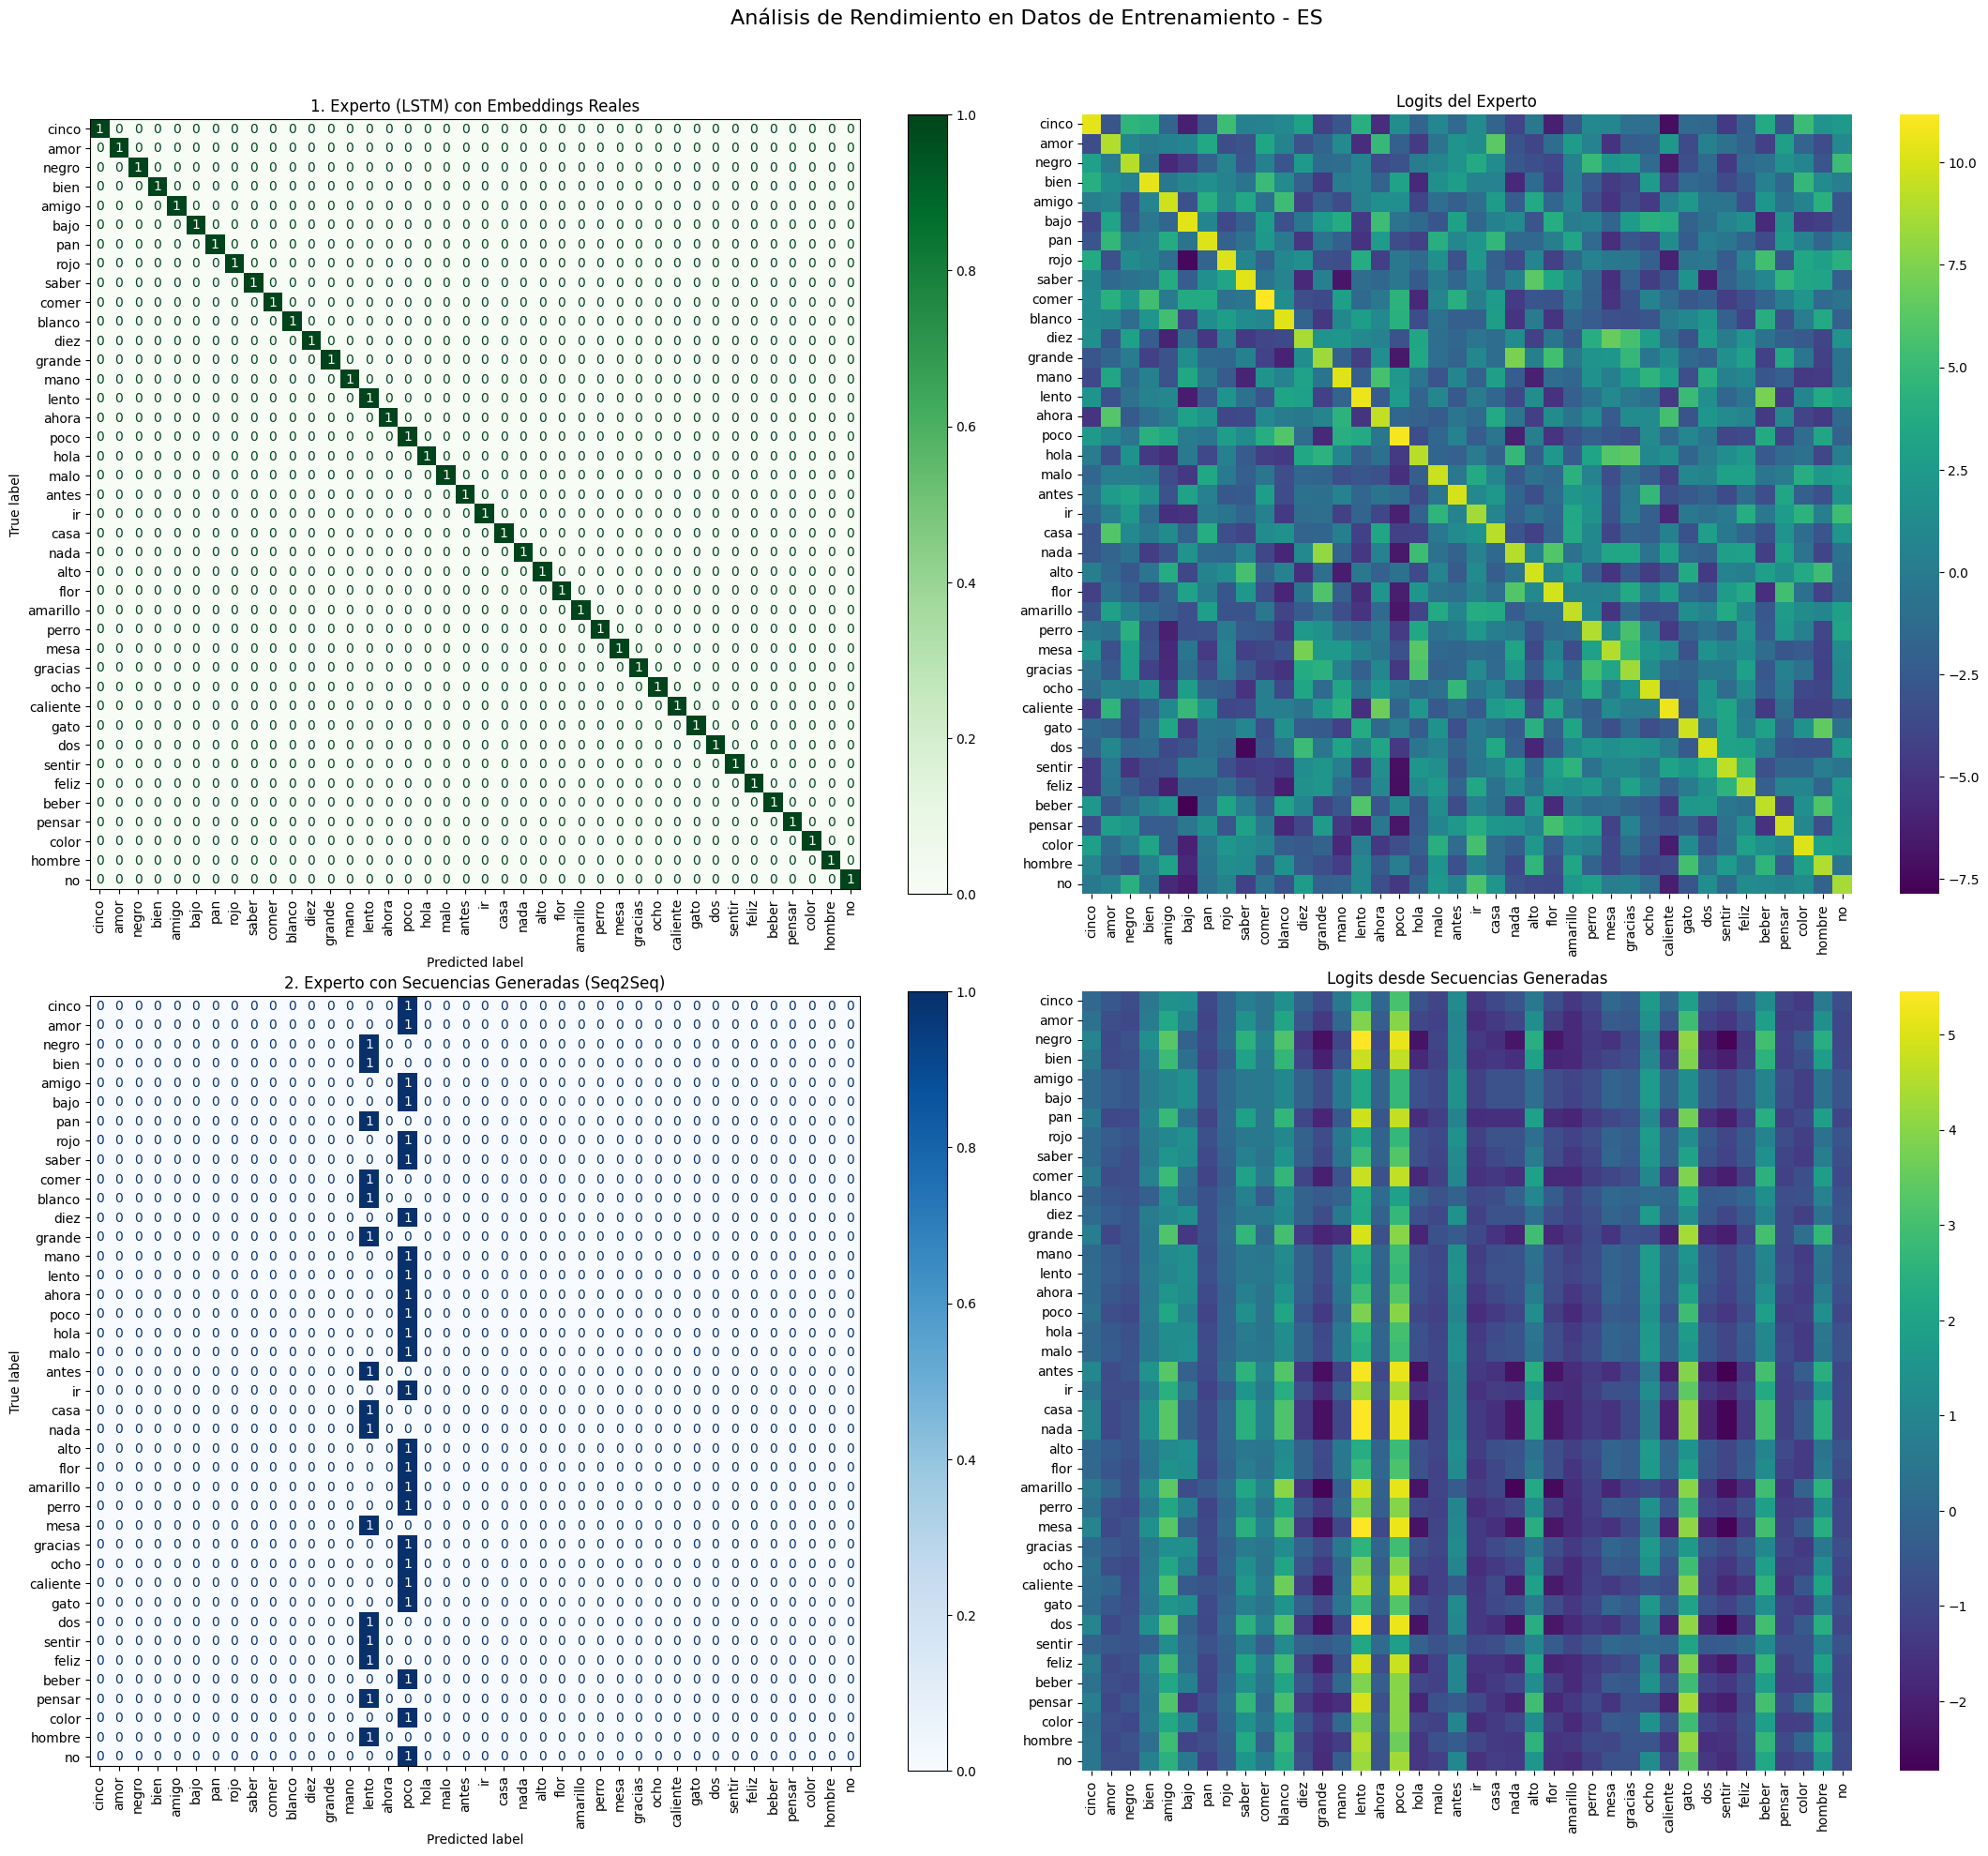


--- Generando métricas de entrenamiento para EN ---


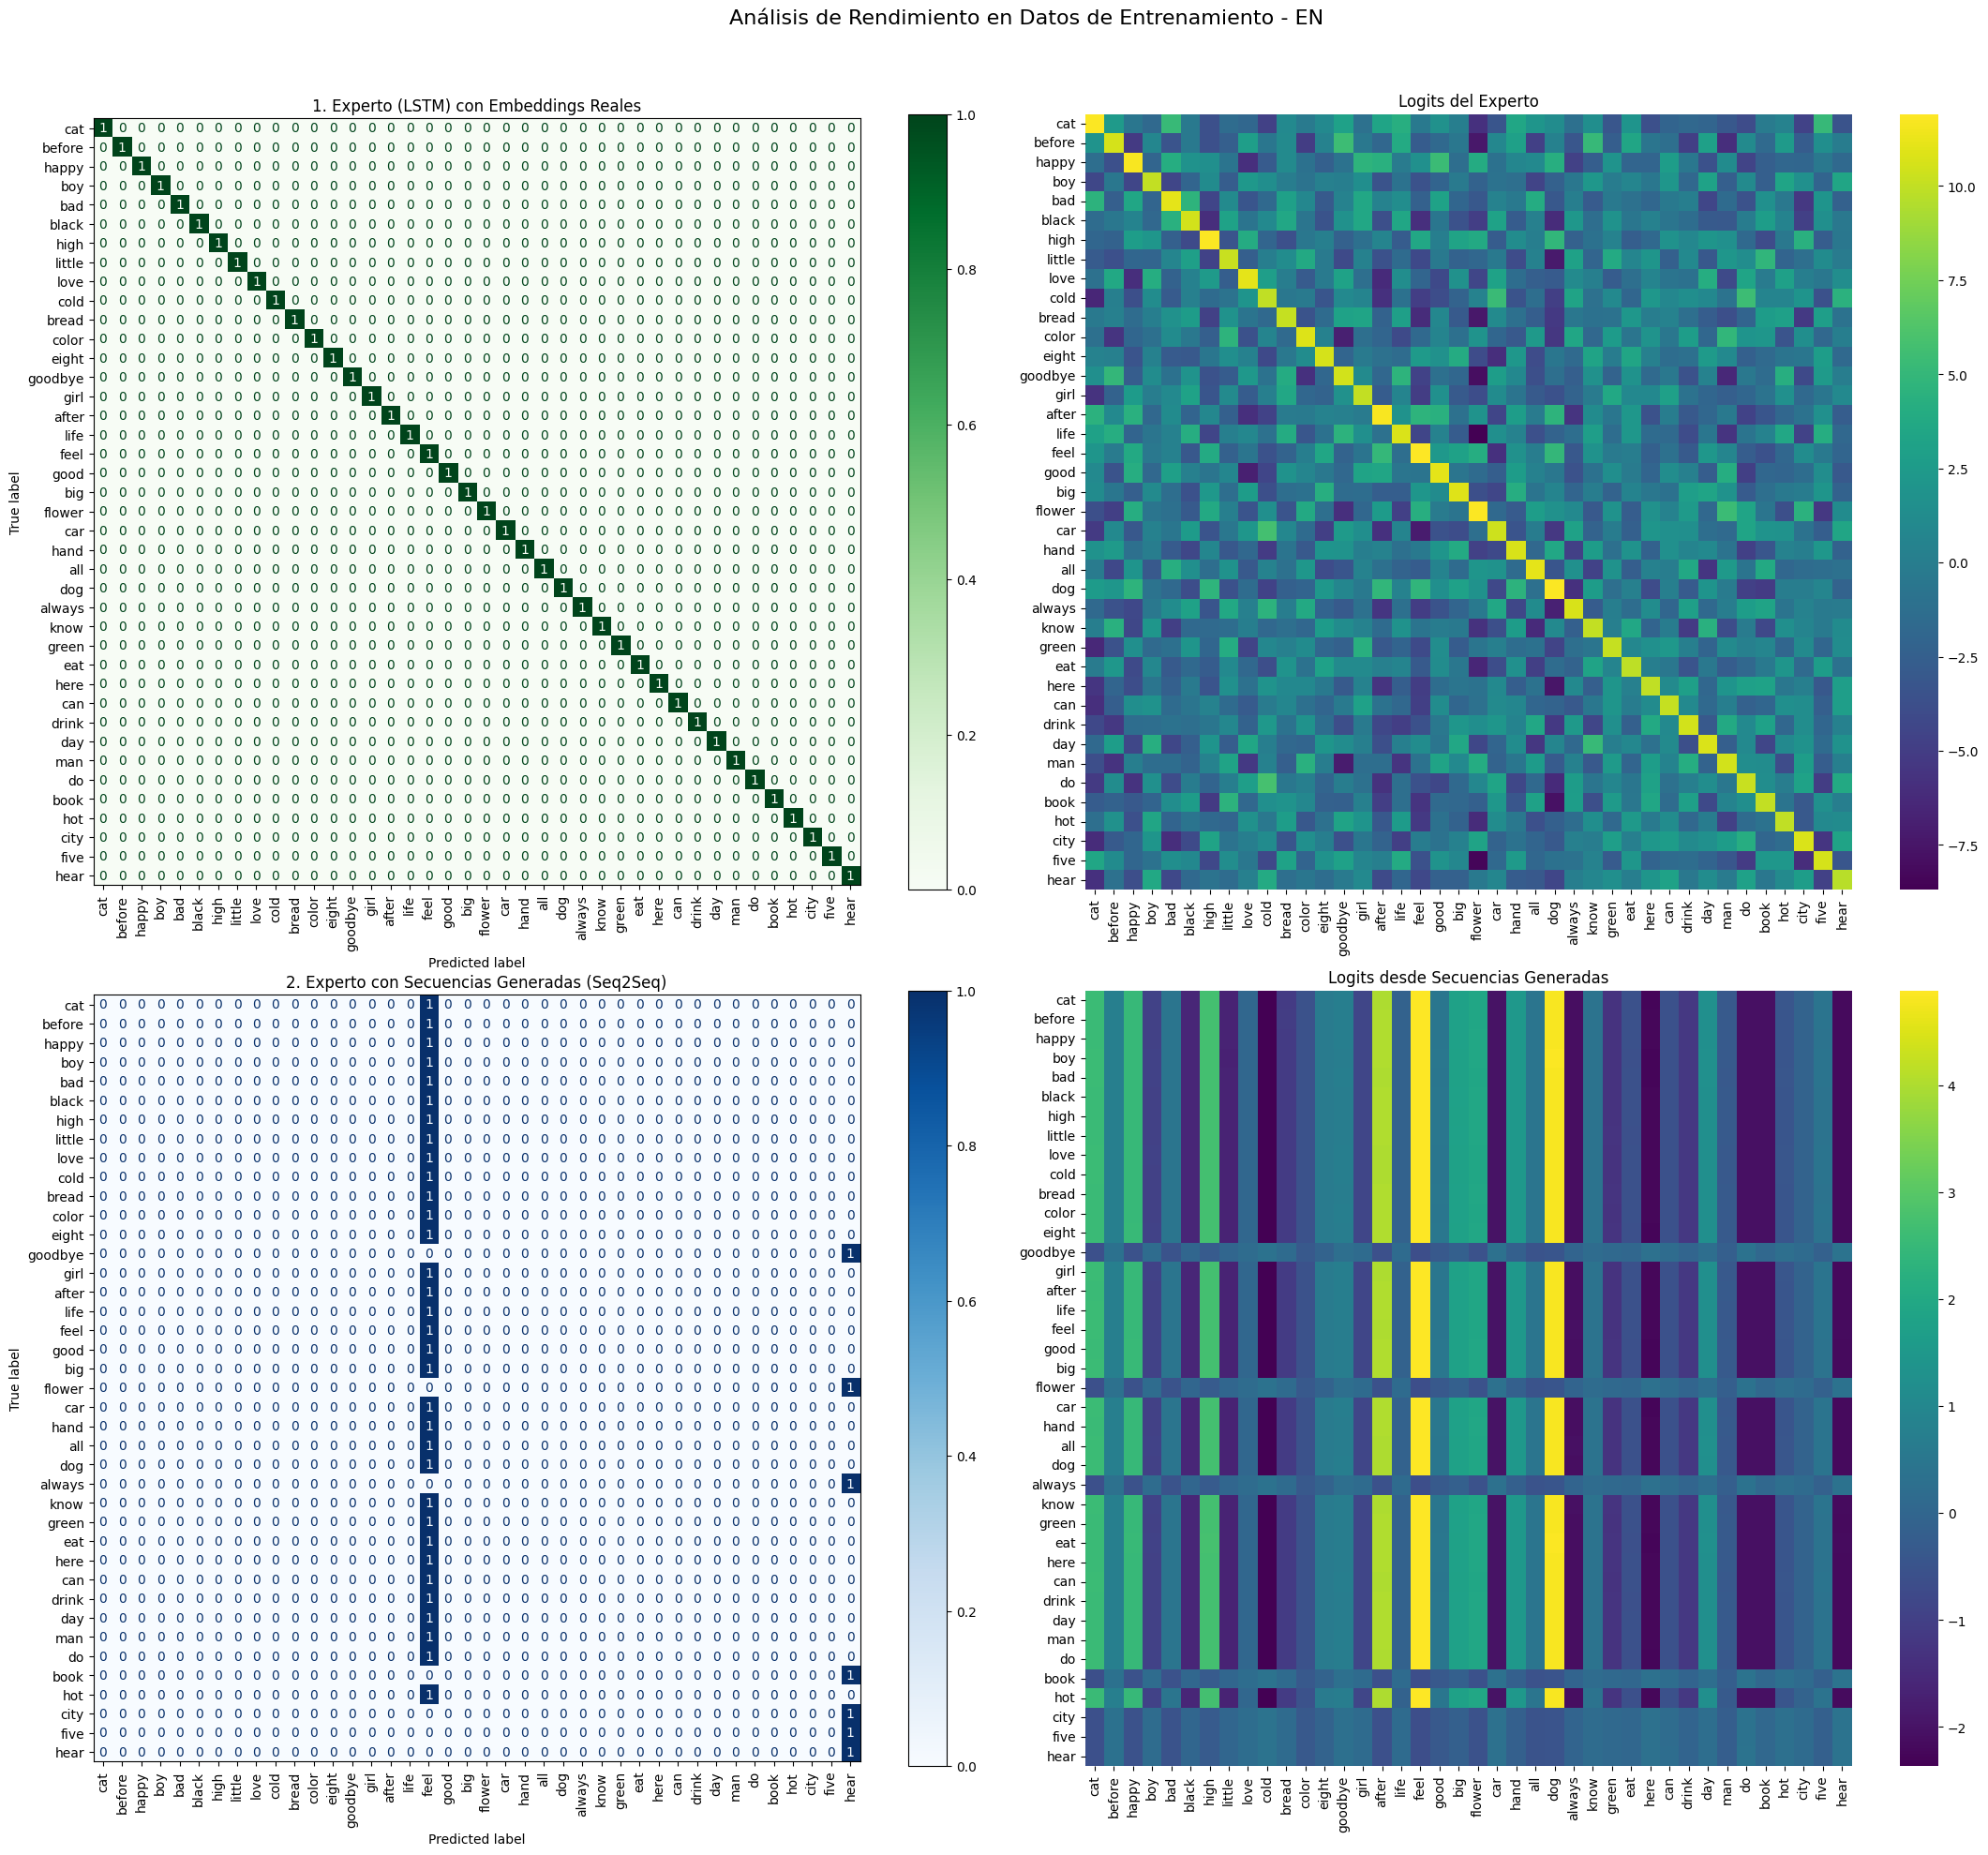

In [6]:
# ===================================================================
# Celda 8: Visualización de Métricas en el Conjunto de Entrenamiento (Seq2Seq)
# ===================================================================
for lang, res in results.items():
    print(f"\n--- Generando métricas de entrenamiento para {lang.upper()} ---")
    validator_model = res['validator_model']; seq2seq_model = res['transformer_model']; train_dataset = res['train_dataset']
    loader_expert_eval = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_sequential_words)
    loader_transformer_eval = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_seq2seq)
    y_true, y_pred_expert, logits_expert, y_pred_transformer, logits_transformer = [], [], [], [], []

    seq2seq_model.eval(); validator_model.eval()
    with torch.no_grad():
        for word_seqs, word_lengths, labels, _ in loader_expert_eval:
            expert_logits_out = validator_model(word_seqs.to(device), word_lengths)
            y_true.extend(labels.numpy()); y_pred_expert.extend(expert_logits_out.argmax(1).cpu().numpy()); logits_expert.append(expert_logits_out.cpu())
        for padded_phonemes, padded_words, word_lengths, labels, _ in loader_transformer_eval:
            phoneme_padding_mask = (padded_phonemes.sum(dim=2) == 0).to(device)
            # Usamos "greedy" decoding (teacher_forcing_ratio = 0) para la evaluación
            generated_seq = seq2seq_model(padded_phonemes.to(device), phoneme_padding_mask, padded_words.to(device), teacher_forcing_ratio=0.0)
            transformer_logits_out = validator_model(generated_seq, word_lengths)
            y_pred_transformer.extend(transformer_logits_out.argmax(1).cpu().numpy()); logits_transformer.append(transformer_logits_out.cpu())

    fig, axes = plt.subplots(2, 2, figsize=(22, 20)); fig.suptitle(f'Análisis de Rendimiento en Datos de Entrenamiento - {lang.upper()}', fontsize=16)
    tick_labels = list(train_dataset.int_to_word.values())
    cm_expert = confusion_matrix(y_true, y_pred_expert); disp_expert = ConfusionMatrixDisplay(confusion_matrix=cm_expert, display_labels=tick_labels); axes[0, 0].set_title("1. Experto (LSTM) con Embeddings Reales"); disp_expert.plot(ax=axes[0, 0], xticks_rotation='vertical', cmap='Greens')
    logits_expert_df = pd.DataFrame(torch.cat(logits_expert).numpy(), index=tick_labels, columns=tick_labels); axes[0, 1].set_title("Logits del Experto"); sns.heatmap(logits_expert_df, ax=axes[0, 1], cmap='viridis')
    cm_transformer = confusion_matrix(y_true, y_pred_transformer); disp_transformer = ConfusionMatrixDisplay(confusion_matrix=cm_transformer, display_labels=tick_labels); axes[1, 0].set_title("2. Experto con Secuencias Generadas (Seq2Seq)"); disp_transformer.plot(ax=axes[1, 0], xticks_rotation='vertical', cmap='Blues')
    logits_transformer_df = pd.DataFrame(torch.cat(logits_transformer).numpy(), index=tick_labels, columns=tick_labels); axes[1, 1].set_title("Logits desde Secuencias Generadas"); sns.heatmap(logits_transformer_df, ax=axes[1, 1], cmap='viridis')
    plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.savefig(figure_dir / f"{lang}_{MODEL_ARCHITECTURE}_training_evaluation.png"); plt.show()


--- Generando visualización t-SNE para ES ---
Calculando proyección t-SNE...


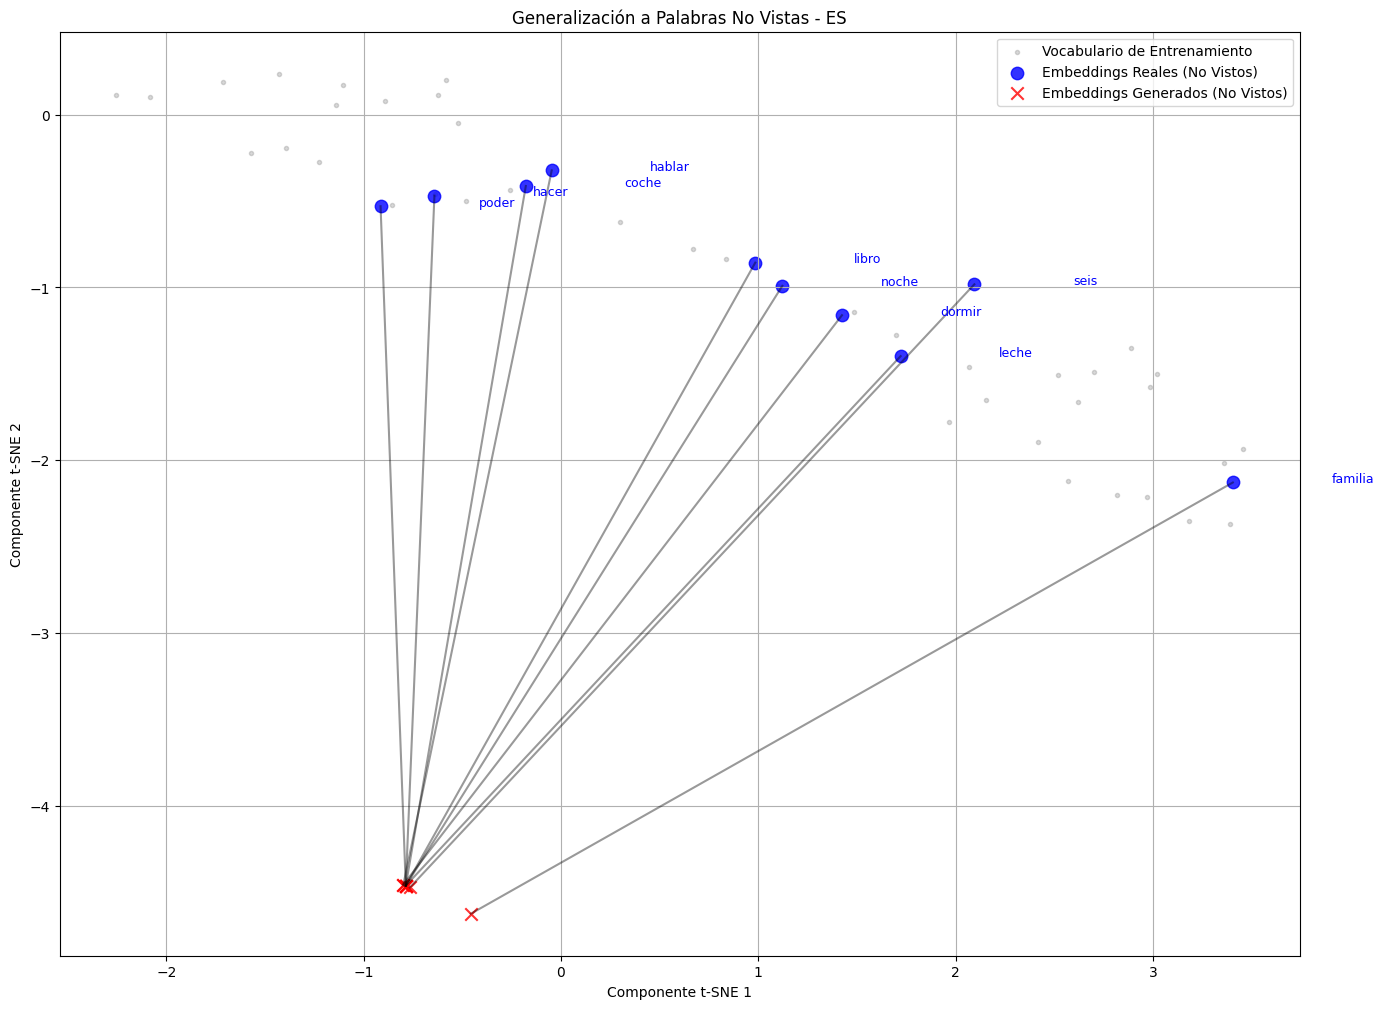

Modelo final para 'es' guardado en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/es_generative_seq2seq_transformer.pth

--- Generando visualización t-SNE para EN ---
Calculando proyección t-SNE...


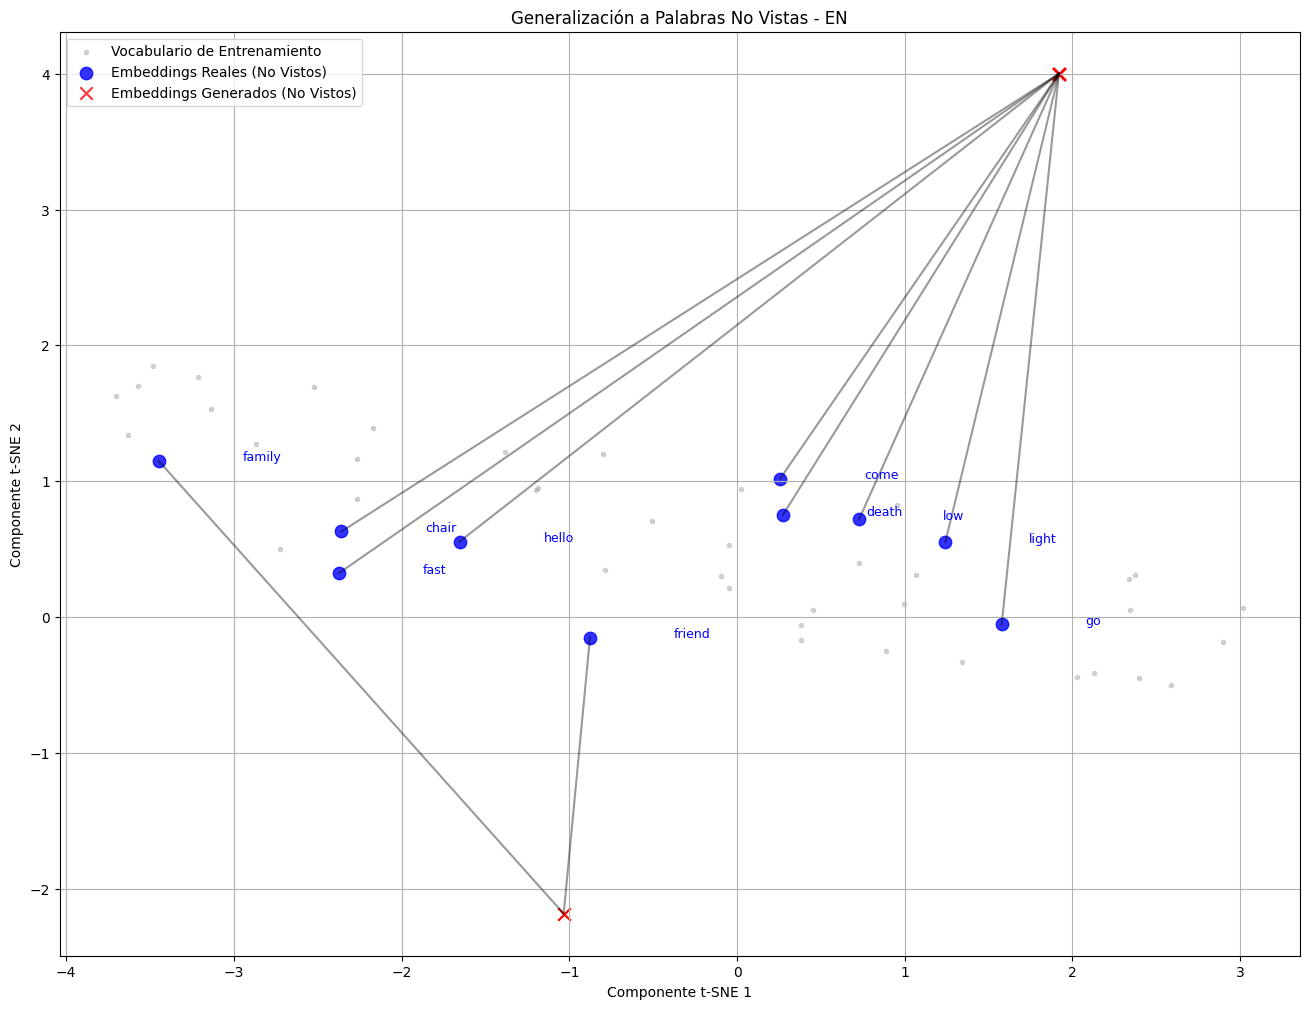

Modelo final para 'en' guardado en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/en_generative_seq2seq_transformer.pth


In [7]:
# ===================================================================
# Celda 10: Visualización de la Generalización con t-SNE (Seq2Seq)
# ===================================================================
for lang, res in results.items():
    print(f"\n--- Generando visualización t-SNE para {lang.upper()} ---")
    seq2seq_model = res['transformer_model']; train_dataset = res['train_dataset']; val_dataset = res['val_dataset']
    # Usamos el collate_fn_seq2seq para ambos loaders
    train_loader_eval = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_seq2seq)
    val_loader_eval = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_seq2seq)
    train_embeds_mean, val_real_embeds_mean, val_pred_embeds_mean = [], [], []

    seq2seq_model.eval()
    with torch.no_grad():
        # --- ¡CORRECCIÓN! Desempaquetamos 5 variables ---
        for _, padded_words, _, _, _ in train_loader_eval:
            train_embeds_mean.append(padded_words.mean(dim=1))
            
        # --- ¡CORRECCIÓN! Desempaquetamos 5 variables ---
        for padded_phonemes, padded_words, _, _, _ in val_loader_eval:
            phoneme_padding_mask = (padded_phonemes.sum(dim=2) == 0).to(device)
            # Usamos "greedy" decoding (teacher_forcing_ratio = 0) para la evaluación
            generated_seq = seq2seq_model(padded_phonemes.to(device), phoneme_padding_mask, padded_words.to(device), teacher_forcing_ratio=0.0)
            val_real_embeds_mean.append(padded_words.mean(dim=1))
            val_pred_embeds_mean.append(generated_seq.mean(dim=1).cpu())
    
    train_embeds_mean = torch.cat(train_embeds_mean).numpy(); val_real_embeds_mean = torch.cat(val_real_embeds_mean).numpy(); val_pred_embeds_mean = torch.cat(val_pred_embeds_mean).numpy()
    combined_embeds = np.vstack([train_embeds_mean, val_real_embeds_mean, val_pred_embeds_mean])
    print("Calculando proyección t-SNE...")
    tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=min(30, len(combined_embeds)-1))
    tsne_results = tsne.fit_transform(combined_embeds)
    
    offset = 0; tsne_train = tsne_results[offset:offset+len(train_embeds_mean)]; offset += len(train_embeds_mean); tsne_val_real = tsne_results[offset:offset+len(val_real_embeds_mean)]; offset += len(val_real_embeds_mean); tsne_val_pred = tsne_results[offset:offset+len(val_pred_embeds_mean)]

    plt.figure(figsize=(16, 12))
    plt.scatter(tsne_train[:, 0], tsne_train[:, 1], c='gray', marker='.', alpha=0.3, label='Vocabulario de Entrenamiento')
    plt.scatter(tsne_val_real[:, 0], tsne_val_real[:, 1], c='blue', marker='o', s=80, alpha=0.8, label='Embeddings Reales (No Vistos)')
    plt.scatter(tsne_val_pred[:, 0], tsne_val_pred[:, 1], c='red', marker='x', s=80, alpha=0.8, label='Embeddings Generados (No Vistos)')
    for i, word in enumerate(val_dataset.word_list):
        plt.plot([tsne_val_real[i, 0], tsne_val_pred[i, 0]], [tsne_val_real[i, 1], tsne_val_pred[i, 1]], 'k-', alpha=0.4)
        plt.text(tsne_val_real[i, 0]+0.5, tsne_val_real[i, 1], word, fontsize=9, color='blue')
    plt.title(f'Generalización a Palabras No Vistas - {lang.upper()}'); plt.xlabel('Componente t-SNE 1'); plt.ylabel('Componente t-SNE 2')
    plt.legend(); plt.grid(True); plt.savefig(figure_dir / f"{lang}_{MODEL_ARCHITECTURE}_tsne_generalization.png"); plt.show()

    model_path = model_dir / f"{lang}_{MODEL_ARCHITECTURE}.pth"
    torch.save(seq2seq_model.state_dict(), model_path)
    print(f"Modelo final para '{lang}' guardado en: {model_path}")